In [2]:
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier, Dataset, cv, train, early_stopping
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import __version__ as sklearn_version
from packaging import version
from multiprocessing import cpu_count
import numpy as np
import shap
import matplotlib.pyplot as plt
import polars as pl
import itertools
import seaborn as sns

# Data Orchestraion 

In [ ]:
try:
    labs = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_labs.csv')
except FileNotFoundError:
    print("Incorrect path to labs file.")

In [4]:
df=pd.read_csv('Model1_AllABX_fixedTime0.csv')
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_abx_class_Glycopeptide,prior_abx_class_Macrolide Lincosamide,prior_abx_class_Monobactam,prior_abx_class_Nitrofuran,prior_abx_class_Nitroimidazole,prior_abx_class_Oxazolidinone,"prior_abx_class_Polymyxin, Lipopeptide",prior_abx_class_Sulfonamide,prior_abx_class_Tetracycline,prior_abx_class_Urinary Antiseptic
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Amikacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ertapenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Meropenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ampicillin,Resistant,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Beta Lactam',
       'prior_abx_class_Combination Antibiotic',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Folate Synthesis Inhibitor',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Macrolide Lincosamide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Polymyxin, Lipopeptide','prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_abx_class_Urinary Antiseptic','prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus',
'ACHROMOBACTER XYLOSOXIDANS_Cefepime',
       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',
       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',
       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',
       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',
       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',
       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',
       'ESCHERICHIA COLI_Ciprofloxacin',
       'KLEBSIELLA PNEUMONIAE_Cefazolin',
       'KLEBSIELLA PNEUMONIAE_Cefepime',
       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',
       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',
       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',
       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',
       'PROTEUS MIRABILIS_Ceftriaxone','PROTEUS MIRABILIS_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Cefepime',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA_Cefazolin',
       'PSEUDOMONAS AERUGINOSA_Cefepime',
       'PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'STAPHYLOCOCCUS AUREUS_Cefazolin',
       'STAPHYLOCOCCUS AUREUS_Ciprofloxacin'
                 ]

In [7]:
labs[lab_features] = labs[lab_features].apply(pd.to_numeric, errors = 'coerce')

In [8]:
for col in categorical_features:
    df[col]=df[col].astype('str')
    df.loc[df[col]=='Null',col]=None
    df[col] = df[col].astype('category')
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors = 'coerce')
df['year'] = df['year'].astype(int)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_abx_class_Glycopeptide,prior_abx_class_Macrolide Lincosamide,prior_abx_class_Monobactam,prior_abx_class_Nitrofuran,prior_abx_class_Nitroimidazole,prior_abx_class_Oxazolidinone,"prior_abx_class_Polymyxin, Lipopeptide",prior_abx_class_Sulfonamide,prior_abx_class_Tetracycline,prior_abx_class_Urinary Antiseptic
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Amikacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ertapenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Meropenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ampicillin,Resistant,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df["case_id"] = df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded"]).ngroup()
df.head()

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_35557/2640269478.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["case_id"] = df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded"]).ngroup()


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_abx_class_Macrolide Lincosamide,prior_abx_class_Monobactam,prior_abx_class_Nitrofuran,prior_abx_class_Nitroimidazole,prior_abx_class_Oxazolidinone,"prior_abx_class_Polymyxin, Lipopeptide",prior_abx_class_Sulfonamide,prior_abx_class_Tetracycline,prior_abx_class_Urinary Antiseptic,case_id
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Amikacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33558
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33558
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ertapenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33558
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Meropenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33558
4,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ampicillin,Resistant,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33558


In [11]:
top_10_organisms = df['organism'].value_counts().head(10).index

In [12]:
ABXs=df.antibiotic.unique()
Relevant_ABX=[]
for abx in ABXs:
   if df[(df.antibiotic==abx)].case_id.nunique()>1000:
       if df[(df.antibiotic==abx)].implied_susceptibility.nunique()>=2:
           Relevant_ABX.append(abx)

In [ ]:
df=df[df.antibiotic.isin(Relevant_ABX)]
df = df[df['organism'].isin(top_10_organisms)]
df.shape

In [15]:
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
df.rename(columns=lambda x: x.replace(",_", "_"), inplace=True)

In [ ]:
identifiers=df[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc']]
identifiers.drop_duplicates(inplace=True)
identifiers_filtered=identifiers.loc[identifiers.groupby(["anon_id", "pat_enc_csn_id_coded"])["order_time_jittered_utc"].idxmin()]
identifiers_filtered = identifiers_filtered.reset_index(drop=True)

In [ ]:
df_index_orders=df.merge(identifiers_filtered,how='inner',on=['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc'])
df=[]
df_index_orders.shape

In [18]:
labs=labs.merge(identifiers_filtered,how='inner',on=['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'])
identifiers_filtered=[]

In [19]:
df_index_orders=df_index_orders.merge(labs,how='left',on=['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'])

In [20]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus',
]

In [21]:
for col in categorical_features:
    df_index_orders[col]=df_index_orders[col].astype('str')
    df_index_orders.loc[df_index_orders[col]=='Null',col]=None
    df_index_orders[col] = df_index_orders[col].astype('category')
df_index_orders[numeric_features] = df_index_orders[numeric_features].apply(pd.to_numeric, errors = 'coerce')
df_index_orders['year'] = df_index_orders['year'].astype(int)
df_index_orders.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc_x,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,first_plt,last_hgb,first_hgb,last_lymphocytes,first_lymphocytes,last_neutrophils,first_neutrophils,last_wbc,first_wbc,order_time_jittered_utc_y
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-23 22:29:00+00:00
1,JC1783302,131294514927,681936151,2020-08-21 11:08:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1,NaN,2020-08-21 11:08:00+00:00
2,JC1783302,131294514927,681936151,2020-08-21 11:08:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-21 11:08:00+00:00
3,JC1783302,131294514927,681936151,2020-08-21 11:08:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-21 11:08:00+00:00
4,JC1783302,131294514927,681936151,2020-08-21 11:08:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1,NaN,2020-08-21 11:08:00+00:00


In [23]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress warnings


### Model training with XGBoost
def train_test_xgb(df, model_antibiotic, features):
    df = df[features + ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'implied_susceptibility', 'year', 'culture_description']]
    df = (
        df[df['antibiotic'] == model_antibiotic]
        .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
        .reset_index(drop=True)
    )
    
    label_enc = LabelEncoder()
    df['implied_susceptibility'] = label_enc.fit_transform(df['implied_susceptibility'])
    label_mapping = dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_)))
    print(label_mapping)
    print('*****************************')
    
    df_train = df[df.year < 2020].drop(columns=['year'])
    df_val = df[df['year'].isin([2020, 2021])].drop(columns=['year'])
    df_test = df[df['year'] >= 2022].drop(columns=['year'])
    
    print('data splits completed ')
    for col in ['antibiotic', 'culture_description']:
        encoder = LabelEncoder()
        encoder.fit(df_train[col])
        df_val = df_val[df_val[col].isin(encoder.classes_)]
        df_test = df_test[df_test[col].isin(encoder.classes_)]
        
        df_train[col] = encoder.transform(df_train[col])
        df_val[col] = encoder.transform(df_val[col])
        df_test[col] = encoder.transform(df_test[col])
    
    X_train, y_train = df_train[features], df_train['implied_susceptibility']
    X_val, y_val = df_val[features], df_val['implied_susceptibility']
    X_test, y_test = df_test[features], df_test['implied_susceptibility']
    print('X train and test and val is generated')
    
    if len(df_test['implied_susceptibility'].unique()) <= 1:
        print('Not enough data for test')
        return
    
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Feature names in train and test sets do not match")
    
    selected_features = tune_rfe(X_val, y_val)
    X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]

    
    best_params = tune_xgb(X_train, y_train)
    best_params.update({"eval_metric": "auc"})

    print('tune xgb for best params is done',best_params)

    
    model = XGBClassifier(**best_params, use_label_encoder=False,early_stopping_rounds=30, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    predictions = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    predicted_classes = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(y_test, predicted_classes)
    
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, predictions)
    if train_auc - test_auc > 0.1:
        print("Warning: Possible overfitting detected")
    
    return {
        'antibiotic': model_antibiotic.title(),
        'model': model,
        'selected_features': selected_features,
        'best_tune': best_params,
        'df_train': df_train,
        'df_test': df_test,
        'predictions': predictions,
        'auc': auc,
        'roc': {'fpr': fpr, 'tpr': tpr},
        'cm': cm
    }

### RFE Feature selection
def tune_rfe(X, y):
    
    feature_counts = [30, 50, 70, 90, len(X.columns)]
    best_auc = np.NINF
    best_n_features = 30
    best_features=[]
    for n_features in feature_counts:
        model = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
        rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)
        rfe.fit(X, y)

        # Use `.loc` to select features correctly
        X_selected = X.loc[:, rfe.support_]
        auc = cross_val_auc(X_selected, y)  # Ensure this function is defined

        if auc > best_auc:
            best_auc = auc
            best_n_features = n_features
            best_features=X.columns[rfe.support_]
    return best_features

### Hyperparameter Tuning for XGBoost

def tune_xgb(X, y):
    param_distributions = {
        'learning_rate': uniform(0.001, 0.1),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'lambda': uniform(0, 100),
        'alpha': uniform(0, 100),
        'max_depth': randint(3, 12),
        'n_estimators': randint(50, 100),
    }
    
    model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)
    
    search = RandomizedSearchCV(model, param_distributions, n_iter=30, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    search.fit(X, y)
    return search.best_params_

### Cross-validation AUC Score
def cross_val_auc(X, y):
    model = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='auc', random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return np.mean(scores)


In [ ]:
model_features = ['antibiotic'] + numeric_features + lab_features
model_features = [feature.replace(" ", "_") for feature in model_features]
model_features = [feature.replace(",_", "_") for feature in model_features]

In [25]:
Sotre_Models_microbial={}
Sotre_Models={}

In [ ]:
for abx in Relevant_ABX:
    print(abx)
    if df_index_orders[df_index_orders.antibiotic==abx].implied_susceptibility.nunique()>1:
        model_abx = train_test_xgb(df_index_orders,abx, model_features)
        Sotre_Models_microbial[abx]=model_abx
        print('****************************')

In [28]:
for pre_model in Sotre_Models_microbial.keys():
    model=Sotre_Models_microbial[pre_model]
    if model:
        auc=model['auc']
        fpr1, tpr1 = model['roc']['fpr'], model['roc']['tpr']
        index=np.where(tpr1>=0.8)[0][0]
        sen=tpr1[index]
        spec=1-fpr1[index]

        prevalence = model['df_test']['implied_susceptibility'].sum() / len(model['df_test'])
        ppv = (sen * prevalence) / ((sen * prevalence) + ((1 - spec) * (1 - prevalence)))
        npv = (spec * (1 - prevalence)) / (((1 - sen) * prevalence) + (spec * (1 - prevalence)))
        print(pre_model,auc,ppv,npv)
        break

Cefepime 0.6567805602716468 0.9842027920646583 0.047008547008546994


Cefepime 0.6567805602716468 0.8001792114695341 0.4342105263157895


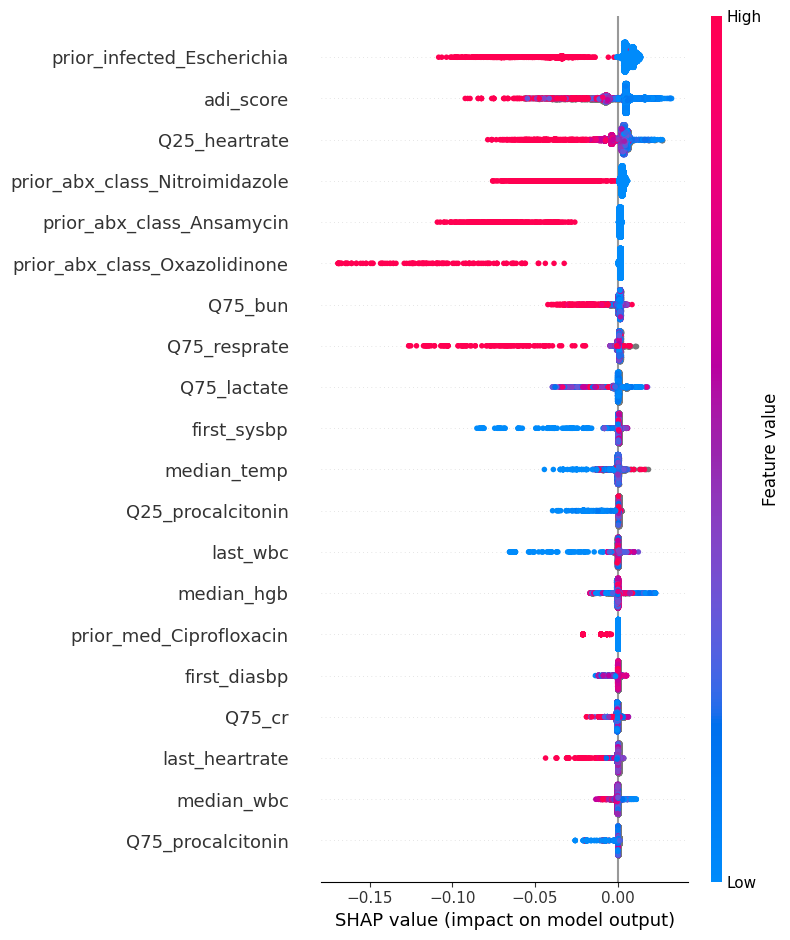

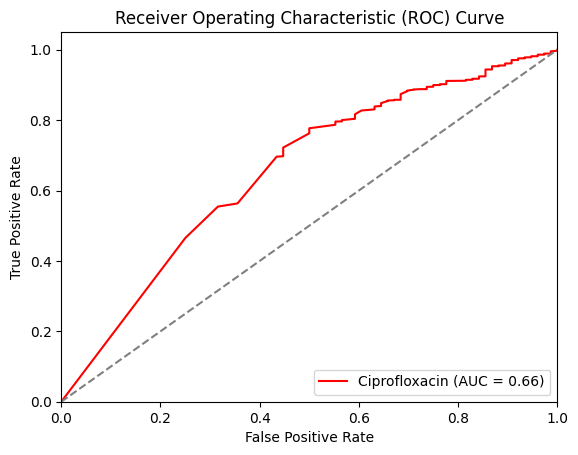

In [33]:
def plot_shap_importance(model):
    features = model['selected_features']
    model['df_train'].columns = model['df_train'].columns.str.replace(' ', '_')
    model['df_test'].columns = model['df_test'].columns.str.replace(' ', '_')

    X_train = model['df_train'][features]
    X_test = model['df_test'][features]

    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

    explainer = shap.Explainer(model['model'])

    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)

for pre_model in Sotre_Models_microbial.keys():
    model=Sotre_Models_microbial[pre_model]
    if model:
        auc=model['auc']
        fpr1, tpr1 = model['roc']['fpr'], model['roc']['tpr']
        index=np.where(tpr1>=0.8)[0][0]
        sen=tpr1[index]
        spec=1-fpr1[index]
        print(pre_model,auc,sen,spec)

        plot_shap_importance(model)

        ### plot model metrics
        fpr1, tpr1 = model['roc']['fpr'], model['roc']['tpr']


        plt.figure()

        # plot ciprofloxacin model
        plt.plot(fpr1, tpr1, color='red', label=f'Ciprofloxacin (AUC = {auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        break    